<hr>

# Neural Networks Project - Gesture recognition

#### Submitter:
    - Pankaj Dixit
<hr>

#### Import the required modules

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
import datetime
import os
import abc
from abc import ABC
import cv2
import matplotlib.pyplot as plt
# % matplotlib inline
from tensorflow.keras.optimizers import Adam
import skimage.transform

C:\Users\dixitp\Anaconda3\envs\tf-2.0\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

#### Set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
# tf.set_random_seed(30)

In [4]:
# train_doc = np.random.permutation(open('./train.csv').readlines())
# val_doc = np.random.permutation(open('./val.csv').readlines())

## ModelCreator Class

Generic Class that is responsible for model creation, training and initialization of model params & hyperparams.

In [5]:
data_path='./'

In [6]:
# ModelCreator Class defination
class ModelCreator(metaclass=abc.ABCMeta):
    # Function to initialize the path where project data resides
    def __init__(self,data_path):
        self.train_doc = np.random.permutation(open(data_path + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(data_path + '/' + 'val.csv').readlines())
        self.train_path = data_path + '/' + 'train'
        self.val_path =  data_path + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # Function to initialize the image properties
    def initImageData(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30

    # Function to initialize the Hyperparams -  batch size, frames to sample and the no. of epochs
    def initHyperParams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

    # The modelGen function        
    def modelGen(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1, self.frames_to_sample)).astype(int)
        print(img_idx)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.dataPerBatch(source_path, t, batch, batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.dataPerBatch(source_path, t, num_batches, batch_size, img_idx, augment, remaining_seq)
                yield batch_data, batch_labels 

    # Data of each batch
    def dataPerBatch(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 

        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                # image reading & resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=skimage.transform.resize(image,(self.image_height,self.image_width,3))

                # normalizing the image
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-10,10)], [0, 1, np.random.randint(-10,10)]]),
                                             (image.shape[1], image.shape[0])
                                            )
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # To have the targeted gestures, crop the images and remove its noise.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=skimage.transform.resize(cropped,(self.image_height,self.image_width,3))
                               
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        return(batch_data,batch_labels)
    
    
    def trainModel(self, model, augment_data=False):
        train_modelGen = self.modelGen(self.train_path, self.train_doc,augment=augment_data)
        val_modelGen = self.modelGen(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history = model.fit_generator(train_modelGen, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_modelGen, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def defModel(self):
        pass

In [7]:
# Utility function to plot the training & validation accuracies/losses.

def plot(Model):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(Model.history['loss'])   
    axes[0].plot(Model.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(Model.history['categorical_accuracy'])   
    axes[1].plot(Model.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

<hr>

# 1. Conv3D based Models

#### ModelConv3D - A derived class for Conv3D based models

In [8]:
class ModelConv3D(ModelCreator):

    def defModel(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

<hr>

## <font color='blue'> Model: 1 </font>

    - Batch Size : 32 
    - Image Size : 160 X 160
    - Frames     : 30
    - Epochs     : 15
<hr>

In [30]:
conv3D1 = ModelConv3D(data_path)
conv3D1.initImageData(image_height=160, image_width=160)
conv3D1.initHyperParams(frames_to_sample=30, batch_size=32, num_epochs=15)
conv3D1_model = conv3D1.defModel()
conv3D1_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 80, 80, 32)   

In [31]:
print("Total Params:", conv3D1_model.count_params())
model1 = conv3D1.trainModel(conv3D1_model)

Total Params: 1117061
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.6531 - categorical_accuracy: 0.3756 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
21/21 [==============================] - 1062s 50s/step - loss: 1.6531 - categorical_accuracy: 0.3756 - val_loss: 1.7185 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.71848, saving model to model_init_2022-09-1900_10_45.881482\model-00001-1.65306-0.37557-1.71848-0.21000.h5
Epoch 2/15
21/21 [==============================] - 1017s 49s/step - loss: 0.9738 - categorical_accuracy: 0.6214 - val_loss: 2.2709 - val_categorical_accuracy: 0.1700

Epoch 00002: val_loss did not improve from 1.71848
Epoch 3/15
21/21 [==============================] - 1024s 49s/step - loss: 0.7094 - categorical_accuracy: 0.7451 - val_loss: 3.2692 - val_categorical_accuracy

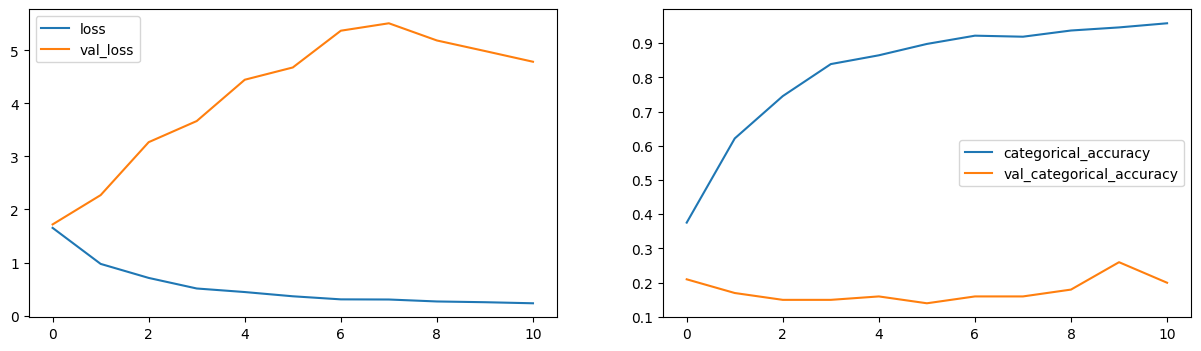

In [33]:
plot(model1)

### Observations:
- This model overfits as the training accuracy is quite high while validation accuracy is too low
- Training accuracy: 95.78%
- Validation accuracy: 20.00%

<hr>

## <font color='blue'> Model: 2 </font>
         Batch Size : 16 
         Image Size : 160 X 160
         Frames     : 30
         Epochs     : 15
<hr>

In [35]:
conv3D2 = ModelConv3D(data_path)
conv3D2.initImageData(image_height=160, image_width=160)
conv3D2.initHyperParams(frames_to_sample=30, batch_size=16, num_epochs=15)
conv3D2_model = conv3D2.defModel()
conv3D2_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 80, 80, 32)    13856     
_________________________________________________________________
activation_9 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 80, 80, 32)   

In [36]:
print("Total Params:", conv3D2_model.count_params())
model2 = conv3D2.trainModel(conv3D2_model)

Total Params: 1117061
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 1.5776 - categorical_accuracy: 0.4103 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
42/42 [==============================] - 1047s 25s/step - loss: 1.5776 - categorical_accuracy: 0.4103 - val_loss: 2.3419 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.34185, saving model to model_init_2022-09-1904_38_15.103392\model-00001-1.57757-0.41026-2.34185-0.16000.h5
Epoch 2/15
42/42 [==============================] - 1045s 25s/step - loss: 0.9058 - categorical_accuracy: 0.6561 - val_loss: 3.3534 - val_categorical_accuracy: 0.1400

Epoch 00002: val_loss did not improve from 2.34185
Epoch 3/15
42/42 [==============================] - 1040s 25s/step - loss: 0.6798 - categorical_accuracy: 0.7436 - val_loss: 4.1904 - val_categorical_accuracy

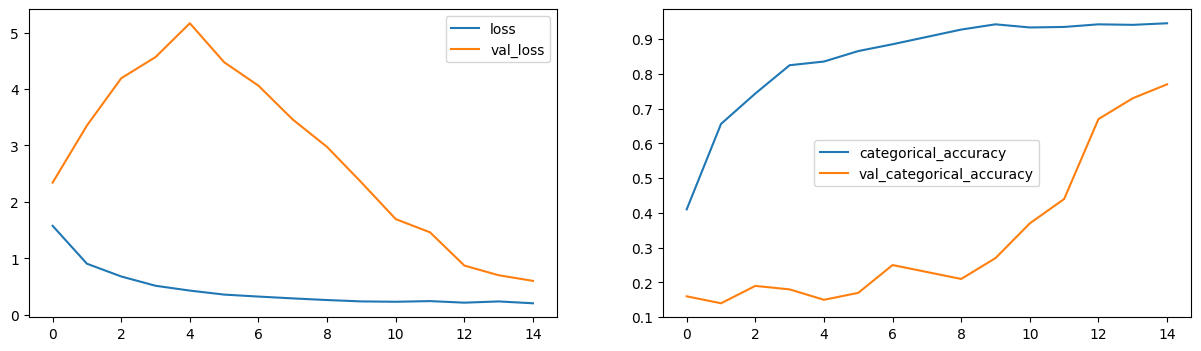

In [37]:
plot(model2)

### Observations:
- This model overfits.
- Training accuracy: 94.57%
- Validation accuracy: 77%

<hr>

## <font color='blue'> Model: 3 </font>
         Batch Size : 16 
         Image Size : 120 X 120
         Frames     : 30
         Epochs     : 15
<hr>

In [38]:
conv3D3 = ModelConv3D(data_path)
conv3D3.initImageData(image_height=120,image_width=120)
conv3D3.initHyperParams(frames_to_sample=30,batch_size=16, num_epochs=15)
conv3D3_model = conv3D3.defModel()
conv3D3_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 60, 60, 32)   

In [39]:
print("Total Params:", conv3D3_model.count_params())
model3 = conv3D3.trainModel(conv3D3_model)

Total Params: 699269
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Epoch 1/15
42/42 [==============================] - ETA: 0s - loss: 1.6819 - categorical_accuracy: 0.3771 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
42/42 [==============================] - 719s 17s/step - loss: 1.6819 - categorical_accuracy: 0.3771 - val_loss: 2.0748 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 2.07481, saving model to model_init_2022-09-1909_39_04.678113\model-00001-1.68187-0.37707-2.07481-0.21000.h5
Epoch 2/15
42/42 [==============================] - 689s 16s/step - loss: 1.0751 - categorical_accuracy: 0.5852 - val_loss: 3.7564 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 2.07481
Epoch 3/15
42/42 [==============================] - 619s 15s/step - loss: 0.8597 - categorical_accuracy: 0.6742 - val_loss: 5.8967 - val_categorical_accuracy: 0.

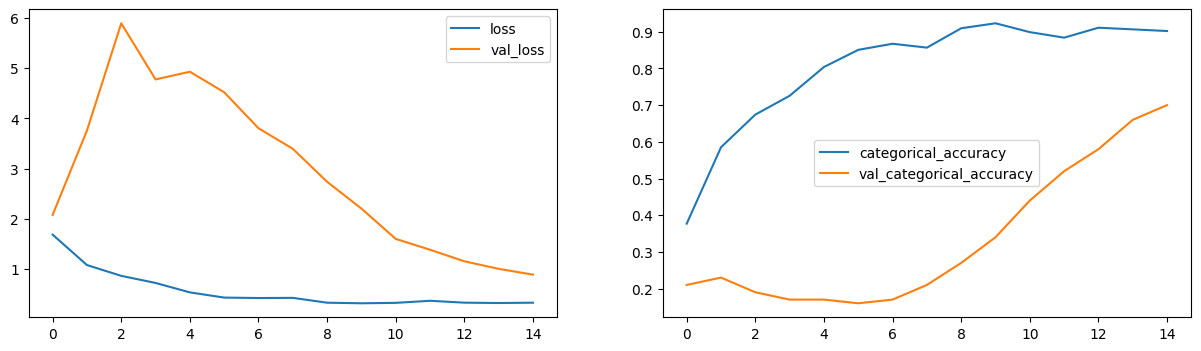

In [40]:
plot(model3)

### Observations:
- This model overfits.
- Training accuracy: 90.20%
- Validation accuracy: 70.0%

<hr>

## <font color='blue'> Model: 4 </font>
         Batch Size : 16 
         Image Size : 120 X 120
         Frames     : 20
         Epochs     : 15
<hr>

In [41]:
conv3D4=ModelConv3D(data_path)
conv3D4.initImageData(image_height=120,image_width=120)
conv3D4.initHyperParams(frames_to_sample=20,batch_size=16,num_epochs=15)
conv3D4_model=conv3D4.defModel()
conv3D4_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_17 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 60, 60, 32)   

In [42]:
print("Total Params:", conv3D4_model.count_params())
model4 = conv3D4.trainModel(conv3D4_model)

Total Params: 699269
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Epoch 1/15
42/42 [==============================] - 451s 11s/step - loss: 1.7251 - categorical_accuracy: 0.3922 - val_loss: 1.9739 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.97391, saving model to model_init_2022-09-1912_42_23.296291\model-00001-1.72509-0.39216-1.97391-0.21000.h5
Epoch 2/15
42/42 [==============================] - 459s 11s/step - loss: 0.9343 - categorical_accuracy: 0.6486 - val_loss: 3.4366 - val_categorical_accuracy: 0.1900

Epoch 00002: val_loss did not improve from 1.97391
Epoch 3/15
42/42 [==============================] - 454s 11s/step - loss: 0.7161 - categorical_accuracy: 0.7481 - val_loss: 4.0947 - val_categorical_accuracy: 0.2400

Epoch 00003: val_loss did not improve from 1.97391
Epoch 4/15
42/42 [==============================] - 458s 11s/step - loss: 0.5828 - categorical_accuracy: 0.8024 - val_loss: 5.4583 - val_categorical_accuracy: 0.1

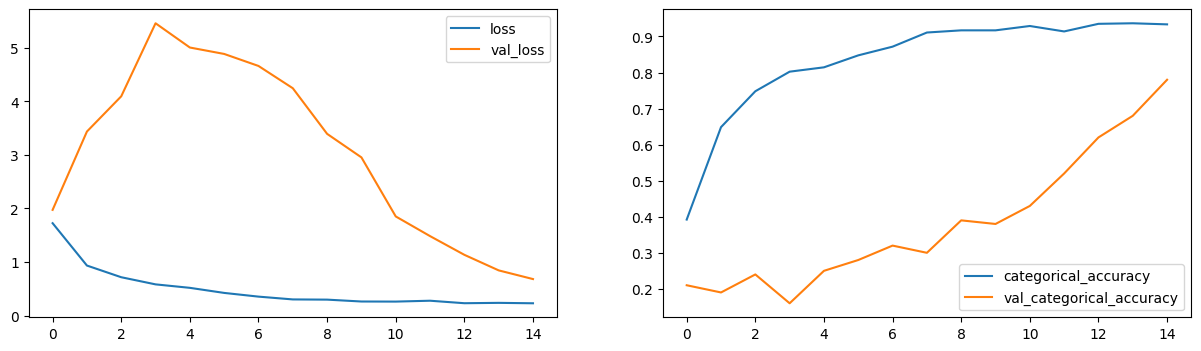

In [43]:
plot(model4)

### Observations:
- This model overfits.
- Training accuracy: 93.36%
- Validation accuracy: 78.00%

<hr>

## <font color='blue'> Model: 5 </font>
         Batch Size : 16 
         Image Size : 120 X 120
         Frames     : 20
         Epochs     : 25
<hr>

In [62]:
conv3D5=ModelConv3D(data_path)
conv3D5.initImageData(image_height=120,image_width=120)
conv3D5.initHyperParams(frames_to_sample=20, batch_size=16, num_epochs=25)
conv3D5_model=conv3D5.defModel()
conv3D5_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_25 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 10, 60, 60, 32)  

In [63]:
print("Total Params:", conv3D5_model.count_params())
model5 = conv3D5.trainModel(conv3D5_model)

Total Params: 699269
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Epoch 1/25
42/42 [==============================] - 315s 8s/step - loss: 1.9179 - categorical_accuracy: 0.3228 - val_loss: 2.1620 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.16204, saving model to model_init_2022-09-2107_03_56.777260\model-00001-1.91789-0.32278-2.16204-0.16000.h5
Epoch 2/25
42/42 [==============================] - 309s 7s/step - loss: 1.2498 - categorical_accuracy: 0.5189 - val_loss: 3.8181 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 2.16204
Epoch 3/25
42/42 [==============================] - 309s 7s/step - loss: 0.8853 - categorical_accuracy: 0.6576 - val_loss: 4.1583 - val_categorical_accuracy: 0.1900

Epoch 00003: val_loss did not improve from 2.16204
Epoch 4/25
42/42 [==============================] - 310s 7s/step - loss: 0.7146 - categorical_accuracy: 0.7391 - val_loss: 4.7592 - val_categorical_accuracy: 0.1400


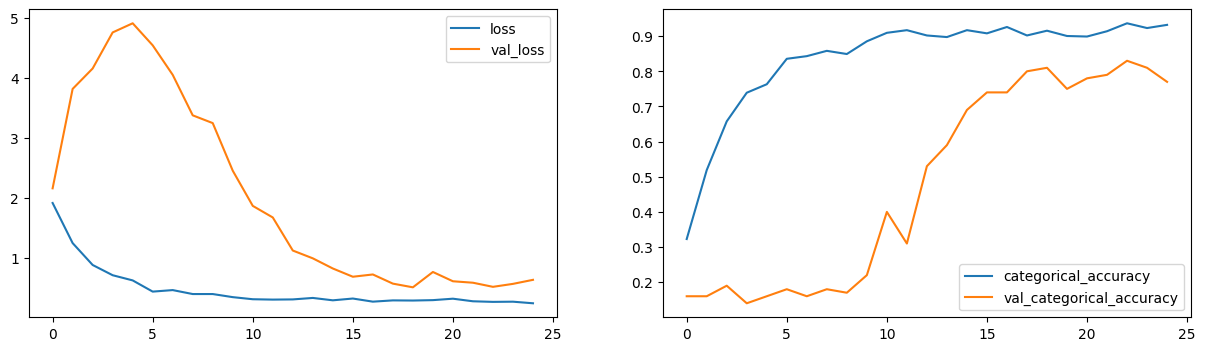

In [64]:
plot(model5)

### Observations:
- This model overfits.
- Training accuracy: 93.21%
- Validation accuracy: 77.00%

<hr>

## <font color='blue'> Model: 6 </font>
         Batch Size        : 16 
         Image Size        : 120 X 120
         Frames            : 20
         Epochs            : 15
         Data Augmentation : Enabled
<hr>

In [9]:
conv3D6=ModelConv3D(data_path)
conv3D6.initImageData(image_height=120,image_width=120)
conv3D6.initHyperParams(frames_to_sample=20,batch_size=16,num_epochs=15)
conv3D6_model=conv3D6.defModel()
conv3D6_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 60, 60, 32)    1

C:\Users\dixitp\Anaconda3\envs\tf-2.0\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [10]:
print("Total Params:", conv3D6_model.count_params())
model6 = conv3D6.trainModel(conv3D6_model, augment_data = True)

Total Params: 699269


C:\Users\dixitp\Anaconda3\envs\tf-2.0\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
Epoch 1/15
42/42 [==============================] - 871s 21s/step - loss: 1.7353 - categorical_accuracy: 0.3688 - val_loss: 2.1903 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 2.19031, saving model to model_init_2022-09-2006_16_37.324574\model-00001-1.73530-0.36878-2.19031-0.21000.h5
Epoch 2/15
42/42 [==============================] - 849s 20s/step - loss: 1.0863 - categorical_accuracy: 0.5890 - val_loss: 3.0276 - val_categorical_accuracy: 0.1700

Epoch 00002: val_loss did not improve from 2.19031
Epoch 3/15
42/42 [==============================] - 853s 20s/step - loss: 0.8898 - categorical_accuracy: 0.6629 - val_loss: 4.1482 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 2.19031
Epoch 4/15
42/42 [==============================] - 907s 22s/step - loss: 0.6172 - categorical_accuracy: 0.7730 - val_loss: 5.8204 - val_categorical_accuracy: 0.1600

Epoch 00004: val

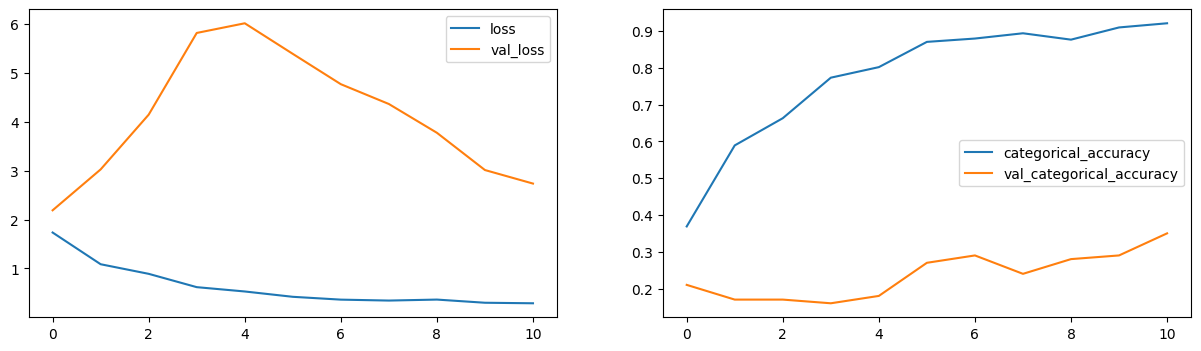

In [11]:
plot(model6)

### Observations:
- This model overfits.
- Training accuracy: 92.08%
- Validation accuracy: 35.00%

<hr>

## <font color='blue'> Model: 7 </font>
         Batch Size        : 16 
         Image Size        : 100 X 100
         Frames            : 16
         Epochs            : 15
         Filter size       : 2X2X2
         Data augmentation : True
<hr>

In [15]:
conv3D7=ModelConv3D(data_path)
conv3D7.initImageData(image_height=100, image_width=100)
conv3D7.initHyperParams(frames_to_sample=16, batch_size=16, num_epochs=15)
conv3D7_model = conv3D7.defModel(filtersize=(2,2,2))
conv3D7_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 100, 100, 16)  400       
_________________________________________________________________
activation_4 (Activation)    (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_5 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 50, 50, 32)    

In [16]:
print("Total Params:", conv3D7_model.count_params())
model7 = conv3D7.trainModel(conv3D7_model, augment_data = True)

Total Params: 387573
[ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Epoch 1/15
42/42 [==============================] - 498s 12s/step - loss: 1.7624 - categorical_accuracy: 0.3635 - val_loss: 1.8824 - val_categorical_accuracy: 0.1700

Epoch 00001: val_loss improved from inf to 1.88242, saving model to model_init_2022-09-2009_01_23.564478\model-00001-1.76241-0.36350-1.88242-0.17000.h5
Epoch 2/15
42/42 [==============================] - 498s 12s/step - loss: 1.0998 - categorical_accuracy: 0.5633 - val_loss: 2.3668 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 1.88242
Epoch 3/15
42/42 [==============================] - 401s 10s/step - loss: 0.8523 - categorical_accuracy: 0.6614 - val_loss: 2.7472 - val_categorical_accuracy: 0.1500

Epoch 00003: val_loss did not improve from 1.88242
Epoch 4/15
42/42 [==============================] - 389s 9s/step - loss: 0.7032 - categorical_accuracy: 0.7345 - val_loss: 3.1872 - val_categorical_accuracy: 0.1900

Epoch 00

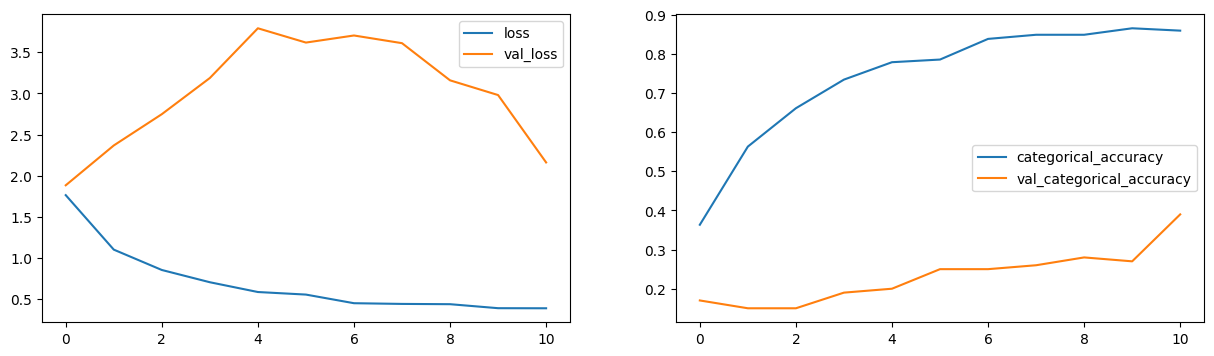

In [17]:
plot(model7)

### Observations:
- This model overfits.
- Training accuracy: 85.97%
- Validation accuracy: 39.00%

<hr>

## <font color='blue'> Model: 8 </font>
         Batch Size        : 16 
         Image Size        : 120 X 120
         Frames            : 16
         Epochs            : 15
         Filter size       : 2X2X2
         dense_neurons     : 128
         Data Augmentation : Enabled
<hr>

In [21]:
conv3D8 = ModelConv3D(data_path)
conv3D8.initImageData(image_height=120, image_width=120)
conv3D8.initHyperParams(frames_to_sample=16, batch_size=16, num_epochs=15)
conv3D8_model=conv3D8.defModel(dense_neurons=128)
conv3D8_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_9 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 60, 60, 32)    

In [22]:
print("Total Params:", conv3D8_model.count_params())
model8 = conv3D8.trainModel(conv3D8_model, augment_data = True)

Total Params: 1113925
[ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Epoch 1/15
42/42 [==============================] - 575s 14s/step - loss: 1.6340 - categorical_accuracy: 0.4140 - val_loss: 2.3777 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.37767, saving model to model_init_2022-09-2010_17_55.272529\model-00001-1.63402-0.41403-2.37767-0.16000.h5
Epoch 2/15
42/42 [==============================] - 544s 13s/step - loss: 0.9830 - categorical_accuracy: 0.6357 - val_loss: 4.2828 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 2.37767
Epoch 3/15
42/42 [==============================] - 615s 15s/step - loss: 0.7114 - categorical_accuracy: 0.7376 - val_loss: 6.1105 - val_categorical_accuracy: 0.1100

Epoch 00003: val_loss did not improve from 2.37767
Epoch 4/15
42/42 [==============================] - 584s 14s/step - loss: 0.5722 - categorical_accuracy: 0.7911 - val_loss: 5.6206 - val_categorical_accuracy: 0.2000

Epoch 

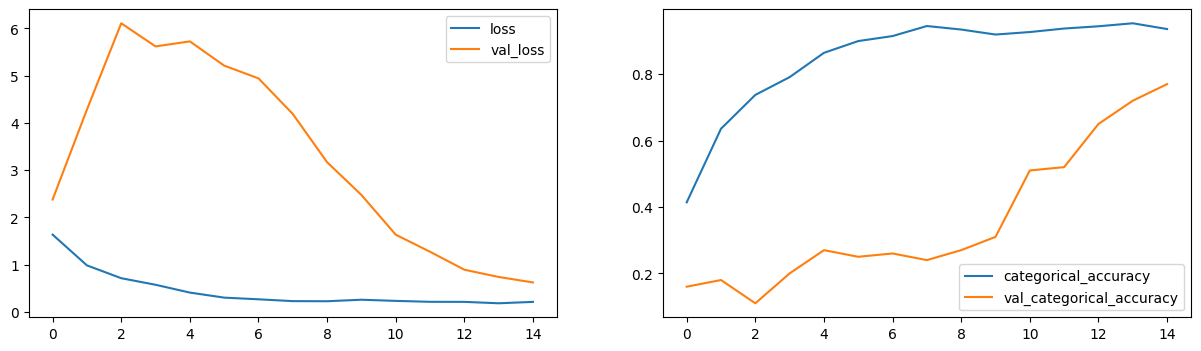

In [23]:
plot(model8)

### Observations:
- This model overfits.
- Training accuracy: 93.59%
- Validation accuracy: 77.00%

<hr>

## <font color='blue'> Model: 9 </font>
         Batch Size        : 16 
         Image Size        : 120 X 120
         Frames            : 16
         Epochs            : 15
         Filter size       : 2X2X2
         dense_neurons     : 256
         Dropout           : 0.5
         Data Augmentation : True
<hr>

In [24]:
conv3D9 = ModelConv3D(data_path)
conv3D9.initImageData(image_height=120,image_width=120)
conv3D9.initHyperParams(frames_to_sample=16,batch_size=16,num_epochs=15)
conv3D9_model=conv3D9.defModel(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3D9_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_12 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_13 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 60, 60, 32)    

In [25]:
print("Total Params:", conv3D9_model.count_params())
model9 = conv3D9.trainModel(conv3D9_model, augment_data = True)

Total Params: 1762613
[ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Epoch 1/15
42/42 [==============================] - 392s 9s/step - loss: 1.9145 - categorical_accuracy: 0.3673 - val_loss: 2.6809 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 2.68087, saving model to model_init_2022-09-2012_36_49.232267\model-00001-1.91448-0.36727-2.68087-0.16000.h5
Epoch 2/15
42/42 [==============================] - 371s 9s/step - loss: 1.1952 - categorical_accuracy: 0.5679 - val_loss: 5.1767 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 2.68087
Epoch 3/15
42/42 [==============================] - 373s 9s/step - loss: 0.8914 - categorical_accuracy: 0.6742 - val_loss: 7.3103 - val_categorical_accuracy: 0.1500

Epoch 00003: val_loss did not improve from 2.68087
Epoch 4/15
42/42 [==============================] - 371s 9s/step - loss: 0.7517 - categorical_accuracy: 0.7247 - val_loss: 8.4151 - val_categorical_accuracy: 0.1900

Epoch 0000

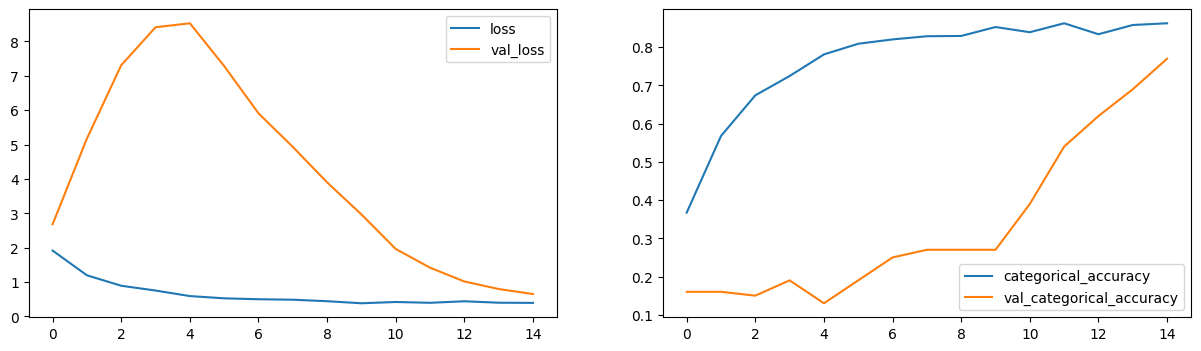

In [26]:
plot(model9)

### Observations:
- This model looks to perform good on training and validation dataset. However, accuracy can be improved further.
- Training accuracy: 86.27%
- Validation accuracy: 77.00%

## <font color='blue'> Model 10: Conv3D Model with increased complexity (more layers) </font>

In [30]:
class ModelConv3D2(ModelCreator):
    
    def defModel(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv3D10 = ModelConv3D2(data_path)
conv3D10.initImageData(image_height=120,image_width=120)
conv3D10.initHyperParams(frames_to_sample=16,batch_size=16,num_epochs=15)
conv3D10_model=conv3D10.defModel(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv3D10_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_16 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 16, 120, 120, 16)  2064      
_________________________________________________________________
activation_17 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 60, 60, 16)    

In [32]:
print("Total Params:", conv3D10_model.count_params())
model10 = conv3D10.trainModel(conv3D10_model, augment_data = True)

Total Params: 1937893
[ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Epoch 1/15
42/42 [==============================] - 696s 16s/step - loss: 2.0983 - categorical_accuracy: 0.3416 - val_loss: 1.8799 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 1.87991, saving model to model_init_2022-09-2014_14_39.043736\model-00001-2.09826-0.34163-1.87991-0.16000.h5
Epoch 2/15
42/42 [==============================] - 662s 16s/step - loss: 1.3385 - categorical_accuracy: 0.5407 - val_loss: 2.6851 - val_categorical_accuracy: 0.1800

Epoch 00002: val_loss did not improve from 1.87991
Epoch 3/15
42/42 [==============================] - 659s 16s/step - loss: 0.9971 - categorical_accuracy: 0.6410 - val_loss: 4.0157 - val_categorical_accuracy: 0.1300

Epoch 00003: val_loss did not improve from 1.87991
Epoch 4/15
42/42 [==============================] - 652s 16s/step - loss: 0.8283 - categorical_accuracy: 0.7036 - val_loss: 4.2913 - val_categorical_accuracy: 0.1900

Epoch 

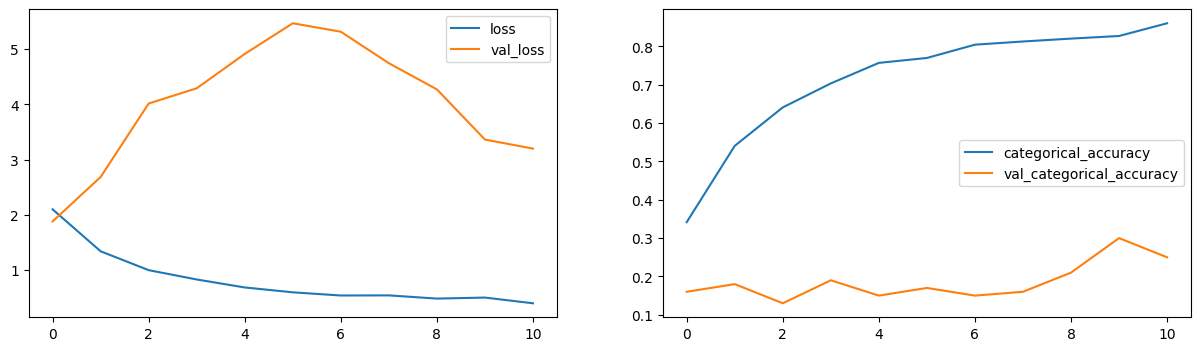

In [33]:
plot(model10)

### Observations:
- Keeping more layers doesn't seem to help much. Further training may help to achieve better accuracy.
- Training accuracy: 86.05%
- Validation accuracy: 25.00%

<hr>

# 2. Conv2D+ RNN based Models

<hr>

## <font color='blue'> 2.a Model:11 LSTM </font>

In [34]:
class CNN_RNN(ModelCreator):
    
    def defModel(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv2D_RNN = CNN_RNN(data_path)
conv2D_RNN.initImageData(image_height=120,image_width=120)
conv2D_RNN.initHyperParams(frames_to_sample=18, batch_size=20, num_epochs=20)
conv2D_RNN_model = conv2D_RNN.defModel(lstm_cells=128, dense_neurons=128, dropout=0.25)
conv2D_RNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)   

In [36]:
print("Total Params:", conv2D_RNN_model.count_params())
conv2D_RNN_model_1 = conv2D_RNN.trainModel(conv2D_RNN_model, augment_data=True)

Total Params: 3392869
[ 0  2  3  5  7  9 10 12 14 15 17 19 20 22 24 26 27 29]
Epoch 1/20
34/34 [==============================] - 285s 8s/step - loss: 1.3974 - categorical_accuracy: 0.4125 - val_loss: 1.6184 - val_categorical_accuracy: 0.1900

Epoch 00001: val_loss improved from inf to 1.61840, saving model to model_init_2022-09-2016_19_37.411657\model-00001-1.39738-0.41252-1.61840-0.19000.h5
Epoch 2/20
34/34 [==============================] - 278s 8s/step - loss: 0.9746 - categorical_accuracy: 0.6237 - val_loss: 1.6203 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 1.61840
Epoch 3/20
34/34 [==============================] - 284s 8s/step - loss: 0.7589 - categorical_accuracy: 0.7391 - val_loss: 1.7314 - val_categorical_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 1.61840
Epoch 4/20
34/34 [==============================] - 278s 8s/step - loss: 0.5947 - categorical_accuracy: 0.8062 - val_loss: 2.0614 - val_categorical_accuracy: 0.2000

Epoc

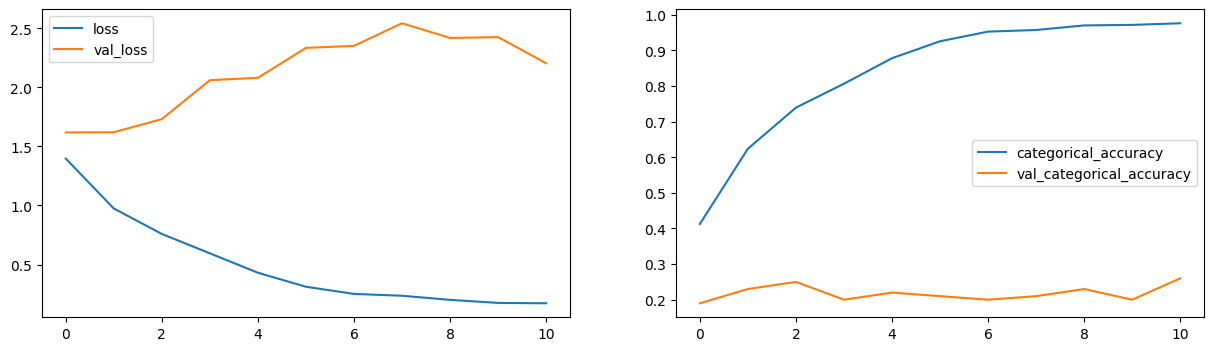

In [37]:
plot(conv2D_RNN_model_1)

### Observations:
- CNN + LSTM overfits.
- Training accuracy: 97.59%
- Validation accuracy: 26.00%

## <font color='blue'> 2.b Model 12: GRU </font>

In [40]:
class CNN_GRU(ModelCreator):
    
    def defModel(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
CNN2D_GRU = CNN_GRU(data_path)
CNN2D_GRU.initImageData(image_height=120, image_width=120)
CNN2D_GRU.initHyperParams(frames_to_sample=18, batch_size=20, num_epochs=20)
CNN2D_GRU_model = CNN2D_GRU.defModel(lstm_cells=128, dense_neurons=128, dropout=0.25)
CNN2D_GRU_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 30, 30, 64)   

In [42]:
print("Total Params:", CNN2D_GRU_model.count_params())
conv2D_RNN_model_2 = CNN2D_GRU.trainModel(CNN2D_GRU_model, augment_data=True)

Total Params: 2573925
[ 0  2  3  5  7  9 10 12 14 15 17 19 20 22 24 26 27 29]
Epoch 1/20
34/34 [==============================] - 319s 9s/step - loss: 1.3038 - categorical_accuracy: 0.4472 - val_loss: 1.5857 - val_categorical_accuracy: 0.2200

Epoch 00001: val_loss improved from inf to 1.58574, saving model to model_init_2022-09-2018_10_51.839290\model-00001-1.30385-0.44721-1.58574-0.22000.h5
Epoch 2/20
34/34 [==============================] - 332s 10s/step - loss: 0.8361 - categorical_accuracy: 0.6848 - val_loss: 1.7124 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 1.58574
Epoch 3/20
34/34 [==============================] - 313s 9s/step - loss: 0.5659 - categorical_accuracy: 0.8054 - val_loss: 2.0160 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.58574
Epoch 4/20
34/34 [==============================] - 303s 9s/step - loss: 0.4286 - categorical_accuracy: 0.8665 - val_loss: 2.3652 - val_categorical_accuracy: 0.2100

Epo

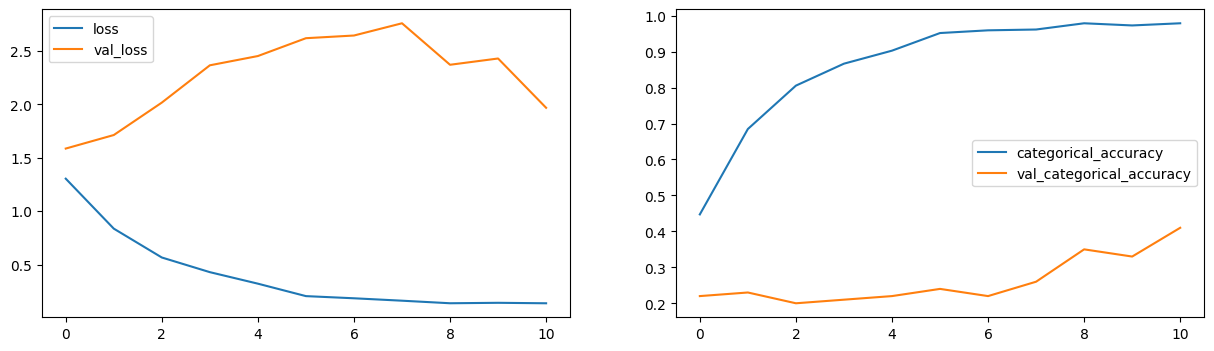

In [43]:
plot(conv2D_RNN_model_2)

### Observations:
- CNN + GRU also overfits. However, it has lesser number of parameters compared to previous LSTM model.
- Training accuracy: 97.89%
- Validation accuracy: 41.00%

# 3. Transfer Learning

## <font color='blue'> 3.a Model 13: Transfer Learning using mobilenet(trainable = False) </font>

In [48]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class Model_TL1(ModelCreator):
    
    def defModel(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [49]:
transfer_learning1 = Model_TL1(data_path)
transfer_learning1.initImageData(image_height=120,image_width=120)
transfer_learning1.initHyperParams(frames_to_sample=16,batch_size=5,num_epochs=20)
transfer_learning_model1=transfer_learning1.defModel(gru_cells=128,dense_neurons=128,dropout=0.25)
transfer_learning_model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_27 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_28 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)              

In [50]:
print("Total Params:", transfer_learning_model1.count_params())
model_tl1 = transfer_learning1.trainModel(transfer_learning_model1, augment_data=True)

Total Params: 3693253
[ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Epoch 1/20
133/133 [==============================] - 209s 2s/step - loss: 1.5355 - categorical_accuracy: 0.3560 - val_loss: 1.0836 - val_categorical_accuracy: 0.5700

Epoch 00001: val_loss improved from inf to 1.08362, saving model to model_init_2022-09-2020_22_38.862984\model-00001-1.53550-0.35596-1.08362-0.57000.h5
Epoch 2/20
133/133 [==============================] - 215s 2s/step - loss: 0.9913 - categorical_accuracy: 0.6094 - val_loss: 0.7890 - val_categorical_accuracy: 0.7100

Epoch 00002: val_loss improved from 1.08362 to 0.78898, saving model to model_init_2022-09-2020_22_38.862984\model-00002-0.99132-0.60935-0.78898-0.71000.h5
Epoch 3/20
133/133 [==============================] - 220s 2s/step - loss: 0.7491 - categorical_accuracy: 0.7278 - val_loss: 0.7257 - val_categorical_accuracy: 0.7400

Epoch 00003: val_loss improved from 0.78898 to 0.72570, saving model to model_init_2022-09-2020_22_38.862984\model-0

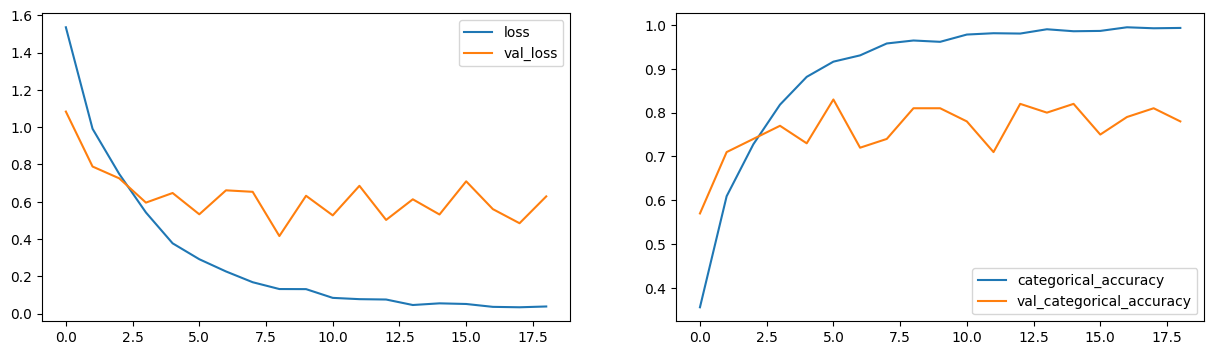

In [51]:
plot(model_tl1)

### Observations:
- mobilenet with keeping layer trainable = False doesn't seem to perform well on validation dataset and model overfits.
- Training accuracy: 99.32%
- Validation accuracy: 78.00%

## <font color='blue'> 3.b Model 14: Transfer Learning using mobilenet(trainable = True)  </font>
Train mobilenet trainable parameters also.

In [52]:
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class Model_TL2(ModelCreator):
    
    def defModel(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [53]:
transfer_learning2 = Model_TL2(data_path)
transfer_learning2.initImageData(image_height=120,image_width=120)
transfer_learning2.initHyperParams(frames_to_sample=16,batch_size=5,num_epochs=20)
transfer_learning_model2 = transfer_learning2.defModel(gru_cells=128,dense_neurons=128,dropout=0.25)
transfer_learning_model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)              

In [54]:
print("Total Params:", transfer_learning_model2.count_params())
model_tl2 = transfer_learning2.trainModel(transfer_learning_model2, augment_data=True)

Total Params: 3693253
[ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]
Epoch 1/20
133/133 [==============================] - 567s 4s/step - loss: 1.2118 - categorical_accuracy: 0.5113 - val_loss: 0.5469 - val_categorical_accuracy: 0.8500

Epoch 00001: val_loss improved from inf to 0.54690, saving model to model_init_2022-09-2021_26_04.287005\model-00001-1.21184-0.51131-0.54690-0.85000.h5
Epoch 2/20
133/133 [==============================] - 566s 4s/step - loss: 0.3867 - categorical_accuracy: 0.8808 - val_loss: 0.2990 - val_categorical_accuracy: 0.9000

Epoch 00002: val_loss improved from 0.54690 to 0.29898, saving model to model_init_2022-09-2021_26_04.287005\model-00002-0.38668-0.88084-0.29898-0.90000.h5
Epoch 3/20
133/133 [==============================] - 568s 4s/step - loss: 0.1797 - categorical_accuracy: 0.9449 - val_loss: 0.2593 - val_categorical_accuracy: 0.9000

Epoch 00003: val_loss improved from 0.29898 to 0.25928, saving model to model_init_2022-09-2021_26_04.287005\model-0

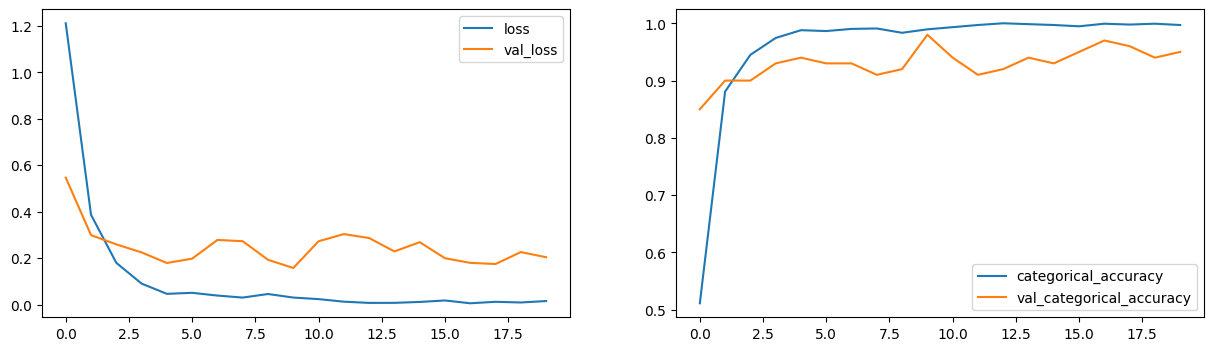

In [55]:
plot(model_tl2)

### Observations:
- mobilenet with keeping layer trainable = True performs very good on given dataset. However, number of trainable parameters are quite high ~3.6M.
- Training accuracy: 99.70%
- Validation accuracy: 95.00%

## Loading and validating final Model

In [67]:
import time
from keras.models import load_model
model = load_model('model-00010-0.03000-0.98944-0.15743-0.98000.h5')

final_model = Model_TL2(data_path)
final_model.initImageData(image_height=120,image_width=120)
final_model.initHyperParams(frames_to_sample=16,batch_size=5,num_epochs=1)

g=final_model.modelGen(final_model.val_path, final_model.val_doc, augment=False)
batch_data, batch_labels=next(g)


[ 0  2  4  6  8 10 12 14 15 17 19 21 23 25 27 29]


In [68]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

# Summary:


- Mobilenet with trainable layer enabled(Model#14) performs well on both the train and val data. Also the accuracy is quite high. So it is the best model out of all the models covered under the above experiment. Its metrics are as below:
    - Training accuracy: 99.70%
    - Validation accuracy: 95.00%
    - Total params: 3,693,253

- Transfer learning models perform better than conv3d and CNN+GRU or CNN+LSTM models.
- Increasing the model complexity further degrades the model performance as it increases overfitting as is evident in Model#10
- Although Model#14 gives us best accuracy numbers but the model params are on the higher side (3,693,253) as compared to  conv3d and CNN+GRU or CNN+LSTM models.
- Change in model performance was not significant while enabling Data augmentation